<a href="https://colab.research.google.com/github/jyj1206/BDA_9th_Pandas/blob/main/6%EC%A3%BC%EC%B0%A8_%EA%B2%B0%EC%B8%A1%EC%B9%983_%26_%EC%9D%B4%EC%83%81%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 또 다른 결측치 처리 방법

In [59]:
# 라이브러리 불러오기
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
# 데이터 불러오기
titanic = sns.load_dataset('titanic')

In [36]:
# 요금 구간을 나누고 나이 결측치를 보간하는 함수 정의
def fill_age_based_on_rules(df):
    # 요금 구간 생성 및 세분화
    df['fare_bin'] = pd.qcut(df['fare'], q=4, labels=['low', 'mid-low', 'mid-high', 'high'])

    # 성별, 승객 등급, 요금 구간별 평균 나이 계산
    age_means = df.groupby(['sex', 'pclass', 'fare_bin'], observed=False)['age'].mean()

    # 결측치 보간 함수
    def fill_age(row):
        if np.isnan(row['age']):  # 나이가 결측치인 경우
          group_mean = age_means.get((row['sex'], row['pclass'], row['fare_bin']))
          # group_mean이 None인 경우 전체 평균 반환 (코드 수정)
          return group_mean if group_mean == np.nan else df['age'].mean()
        return row['age']  # 결측치가 아닌 경우 원래 나이 반환

    # 각 행에 대해 결측치 보간 수행
    df['age'] = df.apply(fill_age, axis=1)
    df.drop(columns=['fare_bin'], inplace=True)
    return df

titanic_cleaned = fill_age_based_on_rules(titanic)

In [37]:
# 결측치 처리 확인
titanic_cleaned['age'].isnull().sum()

0

In [49]:
# 독립변수와 종속변수 설정
X = titanic_cleaned[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked', 'class']]
y = titanic_cleaned['survived']

In [50]:
# 범주형 변수 원핫인코딩 적용
X = pd.get_dummies(X, drop_first=True)

In [54]:
# 학습 및 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# 랜덤포레스트 모델 생성 및 훈련
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 성능 평가
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

train_metrics = evaluate_model(y_train, y_train_pred)
test_metrics = evaluate_model(y_test, y_test_pred)

metrics_df = pd.DataFrame({
    "Train": train_metrics,
    "Test": test_metrics
})

In [56]:
# 결과 확인
metrics_df

,Train,Test
0,0.980337,0.815642
1,0.988462,0.797101
2,0.958955,0.743243
3,0.973485,0.769231


# 이상치 처리

In [78]:
# 데이터 불러오기
# 이상치 처리 실습을 위해 임의의 데이터를 사용함
tips = sns.load_dataset('tips')

In [79]:
data = tips[['total_bill', 'tip', 'size']]

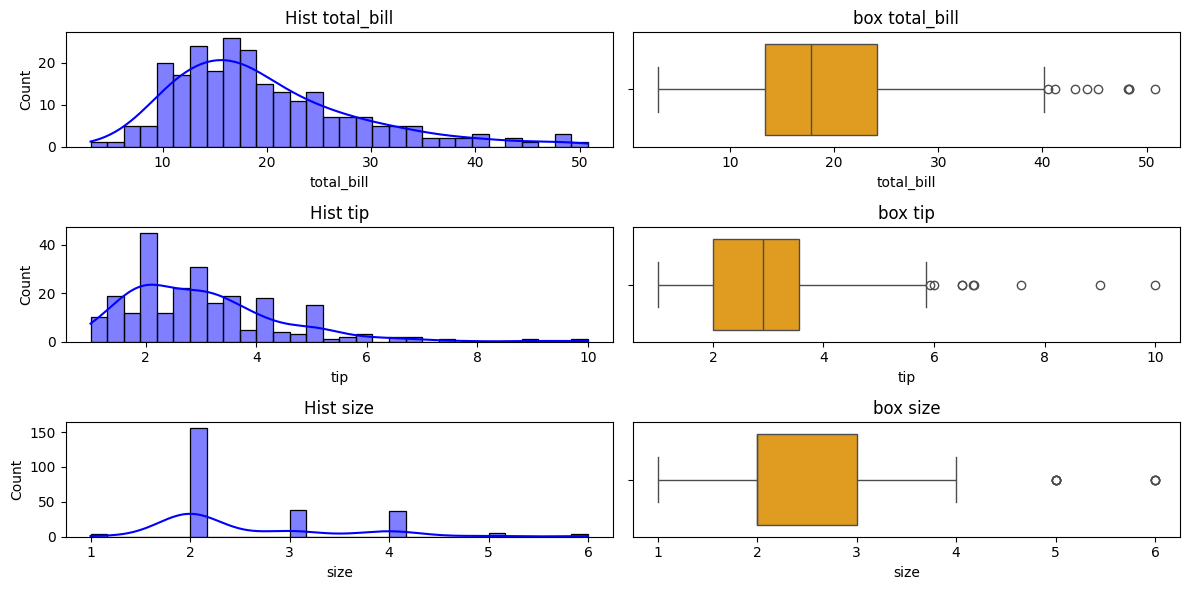

In [80]:
# 히스토그램 및 박스플롯 그리기
fix, axes = plt.subplots(3, 2, figsize=(12, 6))

for i, column in enumerate(data.columns):
  sns.histplot(data[column], bins=30, ax = axes[i,0], kde=True, color='blue')
  axes[i,0].set_title(f'Hist {column}')

  sns.boxplot(x=data[column], ax=axes[i,1], color='orange')
  axes[i,1].set_title(f'box {column}')

fix.tight_layout()
plt.show()

In [90]:
# 이상치 확인 함수
def detect_outliers_iqr(df, column):
    Q1 = np.percentile(df[column], 25)  # 1사분위수
    Q3 = np.percentile(df[column], 75)  # 3사분위수
    IQR = Q3 - Q1  # IQR 계산
    lower_bound = Q1 - 1.5 * IQR  # 이상치 하한
    upper_bound = Q3 + 1.5 * IQR  # 이상치 상한
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# 모든 열에 대해 이상치를 DataFrame으로 결합
outliers_iqr = pd.concat([detect_outliers_iqr(data, col).assign(Column=col) for col in data.columns]).reset_index()

outliers_iqr = outliers_iqr.set_index('Column')

In [91]:
# 이상치 출력
outliers_iqr

,index,total_bill,tip,size
Column,,,,
total_bill,59,48.27,6.73,4
total_bill,102,44.30,2.50,3
total_bill,142,41.19,5.00,5
total_bill,156,48.17,5.00,6
total_bill,170,50.81,10.00,3
total_bill,182,45.35,3.50,3
total_bill,184,40.55,3.00,2
total_bill,197,43.11,5.00,4
total_bill,212,48.33,9.00,4


In [92]:
# 이상치 제거 함수
def remove_outliers_iqr(df, columns):
    total_rows = len(df)
    outlier_indices = []

    # 모든 열에 대해 이상치 탐지
    for column in columns:
        outliers = detect_outliers_iqr(df, column)
        outlier_indices.extend(outliers.index.tolist())

    # 중복된 인덱스 제거
    outlier_indices = list(set(outlier_indices))

    # 이상치 제거
    df_cleaned = df.drop(index=outlier_indices)

    # 제거된 이상치 개수 출력
    removed_count = len(outlier_indices)
    print(f"전체 데이터 중 {removed_count}개의 이상치가 제거되었습니다.")
    print(f"이상치 제거 후 데이터 개수: {len(df_cleaned)}개")

    return df_cleaned

In [106]:
data_cleaned = remove_outliers_iqr(data, data.columns).reset_index(drop=True)

전체 데이터 중 21개의 이상치가 제거되었습니다.
이상치 제거 후 데이터 개수: 223개


In [107]:
# 이상치 제거 후 데이터
data_cleaned

,total_bill,tip,size
0,16.99,1.01,2
1,10.34,1.66,3
2,21.01,3.50,3
3,23.68,3.31,2
4,24.59,3.61,4
...,...,...,...
218,35.83,4.67,3
219,27.18,2.00,2
220,22.67,2.00,2
221,17.82,1.75,2


In [96]:
# IsolationForest를 이용한 이상치 처리 방법
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination = 0.05, random_state=42)
outlier_flags = iso.fit_predict(data)

In [97]:
outliser_iso = data[outlier_flags==-1]

In [98]:
# 이상치 출력
outliser_iso

,total_bill,tip,size
23,39.42,7.58,4
59,48.27,6.73,4
67,3.07,1.00,1
111,7.25,1.00,1
125,29.80,4.20,6
141,34.30,6.70,6
142,41.19,5.00,5
143,27.05,5.00,6
156,48.17,5.00,6
170,50.81,10.00,3


In [105]:
# 이상치 제거 후 데이터
data_cleaned = data[outlier_flags == 1].reset_index(drop=True)

data_cleaned

,total_bill,tip,size
0,16.99,1.01,2
1,10.34,1.66,3
2,21.01,3.50,3
3,23.68,3.31,2
4,24.59,3.61,4
...,...,...,...
226,29.03,5.92,3
227,27.18,2.00,2
228,22.67,2.00,2
229,17.82,1.75,2
